# Configuration

In [1]:
# Import libraries
import datetime          as datetime
import pandas            as pd
import matplotlib.pyplot as plt
import os                as os

from amberdata_derivatives import AmberdataDerivatives

import warnings
warnings.filterwarnings("ignore")

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

# Retrieve API key
API_KEY = os.getenv("API_KEY")

# Amberdata SDK

In [2]:
amberdata_client = AmberdataDerivatives(api_key=API_KEY)

amberdata_client.get

# BTC <> ETH correlation of log daily returns 

Text(0, 0.5, 'Rolling Correlation')

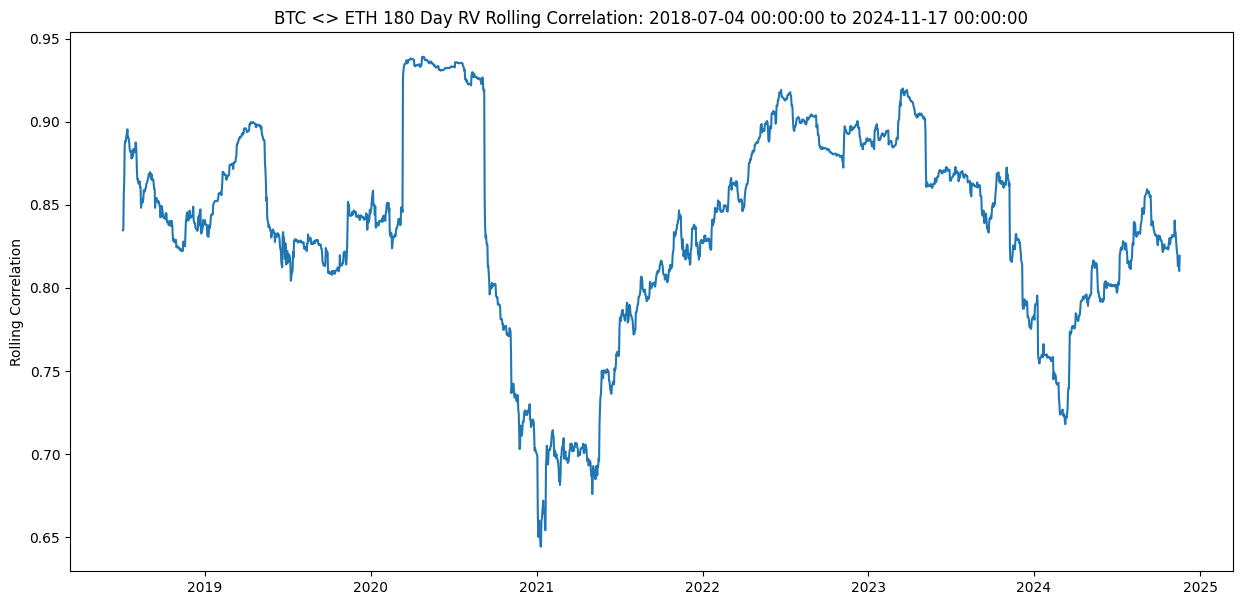

In [3]:
data = amberdata_client.get_realized_volatility_correlation_beta(exchange='gdax', pair='btc_usd', pair2='eth_usd')
data = pd.DataFrame(data['payload']['data'])
data.index = pd.to_datetime(data.timestamp, unit='ms')
data = data[::-1]

plt.figure(figsize=(15, 7))
plt.plot(data.correlation180)
plt.title("BTC <> ETH 180 Day RV Rolling Correlation: " + str(data.index[0]) + " to " + str(data.iloc[-1].name))
plt.ylabel("Rolling Correlation")

# BTC Monthly vs Daily Realized Volatility 

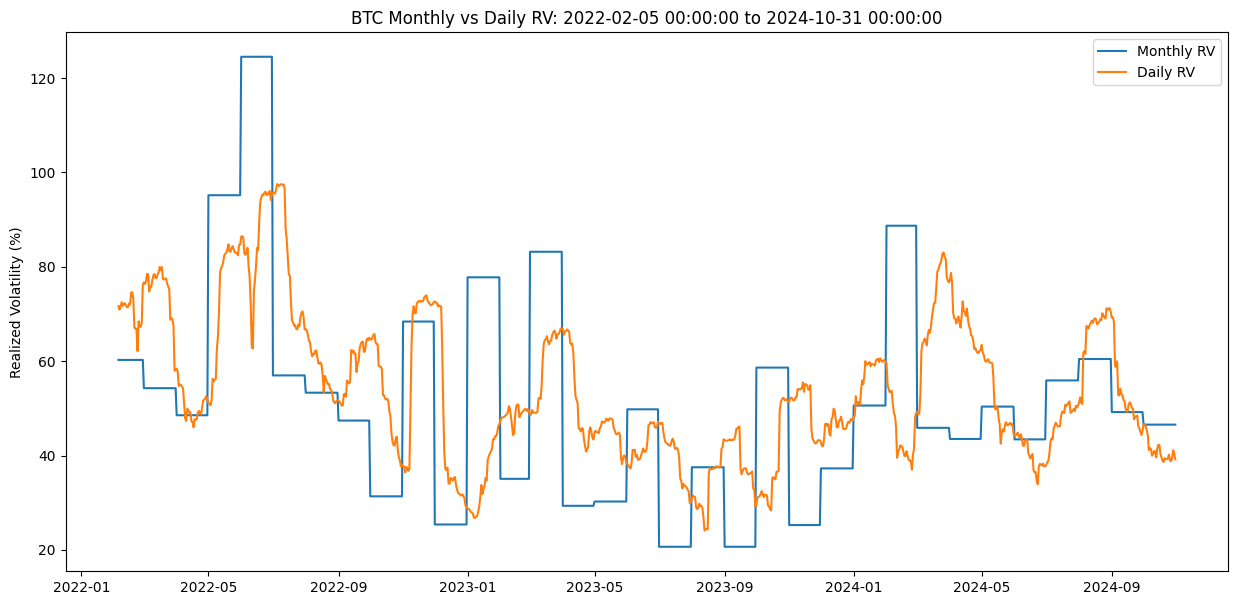

In [4]:
data = amberdata_client.get_realized_volatility_monthly_vs_daily_ratio(exchange='gdax', pair='btc_usd')
data = pd.DataFrame(data['payload']['data'])
data.index = pd.to_datetime(data.timestamp, unit='ms')

# only look at a subset of data
data = data[:1000][::-1]

plt.figure(figsize=(15, 7))
plt.title("BTC Monthly vs Daily RV: " + str(data.index[0]) + " to " + str(data.iloc[-1].name))
plt.plot(data.monthlyHistoricalVolatility, label='Monthly RV')
plt.plot(data.dailyHistoricalVolatility30Days, label='Daily RV')
plt.ylabel("Realized Volatility (%)")
plt.legend();

# BTC volatility seasonality for day of week

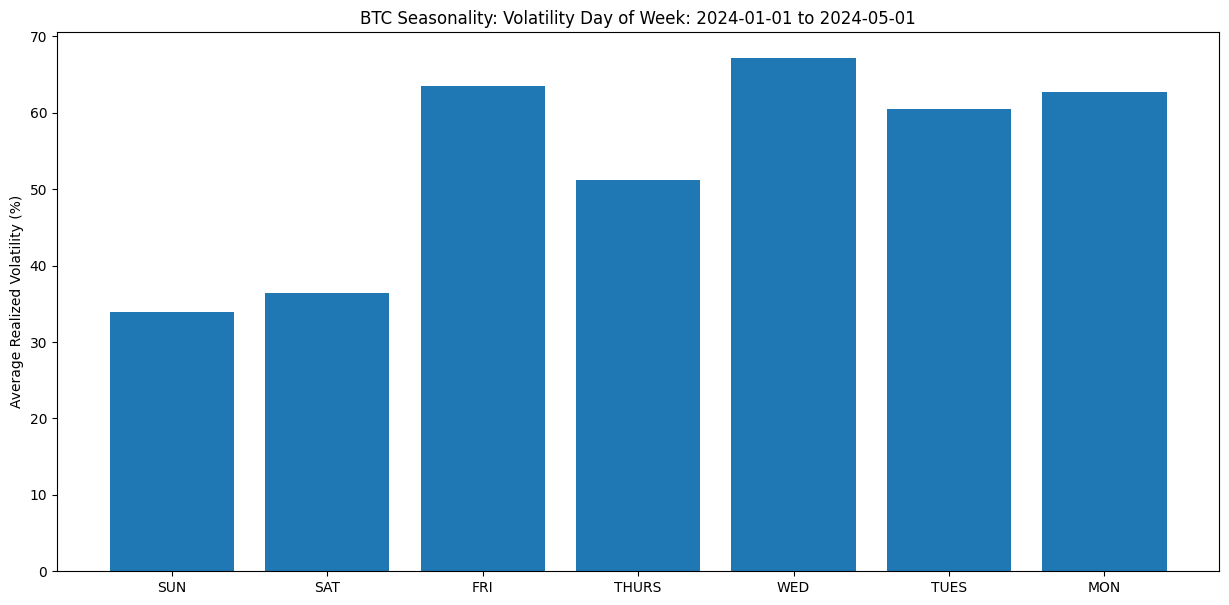

In [5]:
data = amberdata_client.get_realized_volatility_seasonality_day_of_week(exchange='gdax', pair='btc_usd', startDate='2024-01-01', endDate='2024-05-01')
data = pd.DataFrame(data['payload']['data'])
data = data[::-1]

plt.figure(figsize=(15, 7))
plt.bar(data.weekday, data.historicalVolatility1day)
plt.ylabel("Average Realized Volatility (%)")
plt.title("BTC Seasonality: Volatility Day of Week: 2024-01-01 to 2024-05-01");

# BTC volatility seasonality for month of year

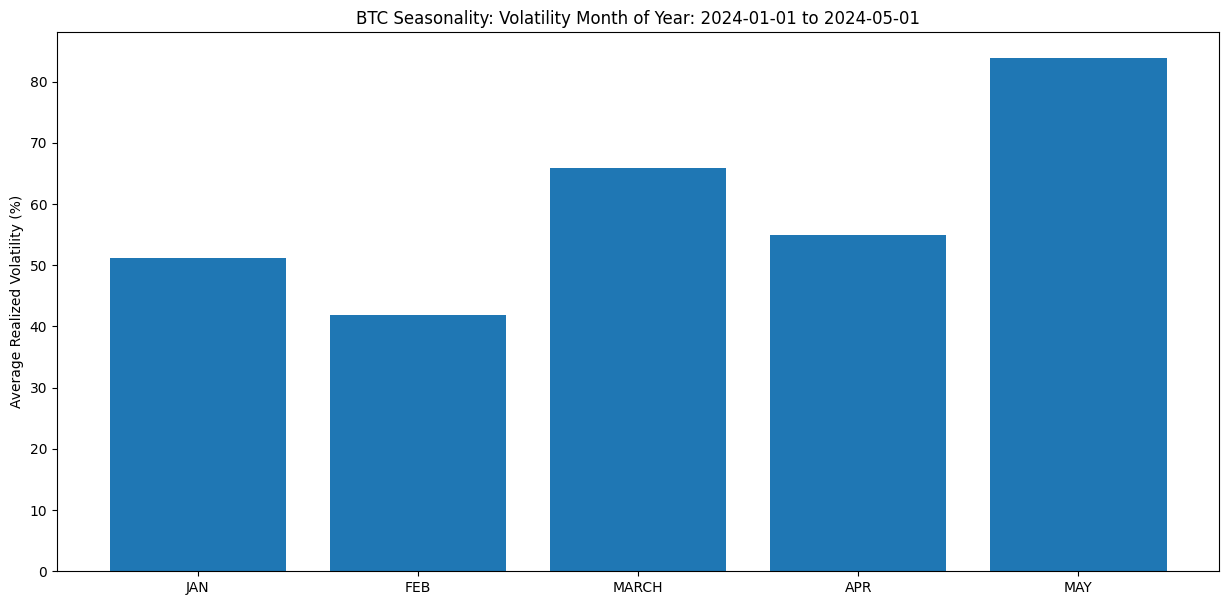

In [6]:
data = amberdata_client.get_realized_volatility_seasonality_month_of_year(exchange='gdax', pair='btc_usd', startDate='2024-01-01', endDate='2024-05-01')
data = pd.DataFrame(data['payload']['data'])

plt.figure(figsize=(15, 7))
plt.bar(data.month, data.historicalVolatility1day)
plt.ylabel("Average Realized Volatility (%)")
plt.title("BTC Seasonality: Volatility Month of Year: 2024-01-01 to 2024-05-01");

# Realized volatility cones for BTC 

Text(0.5, 0, 'DTE')

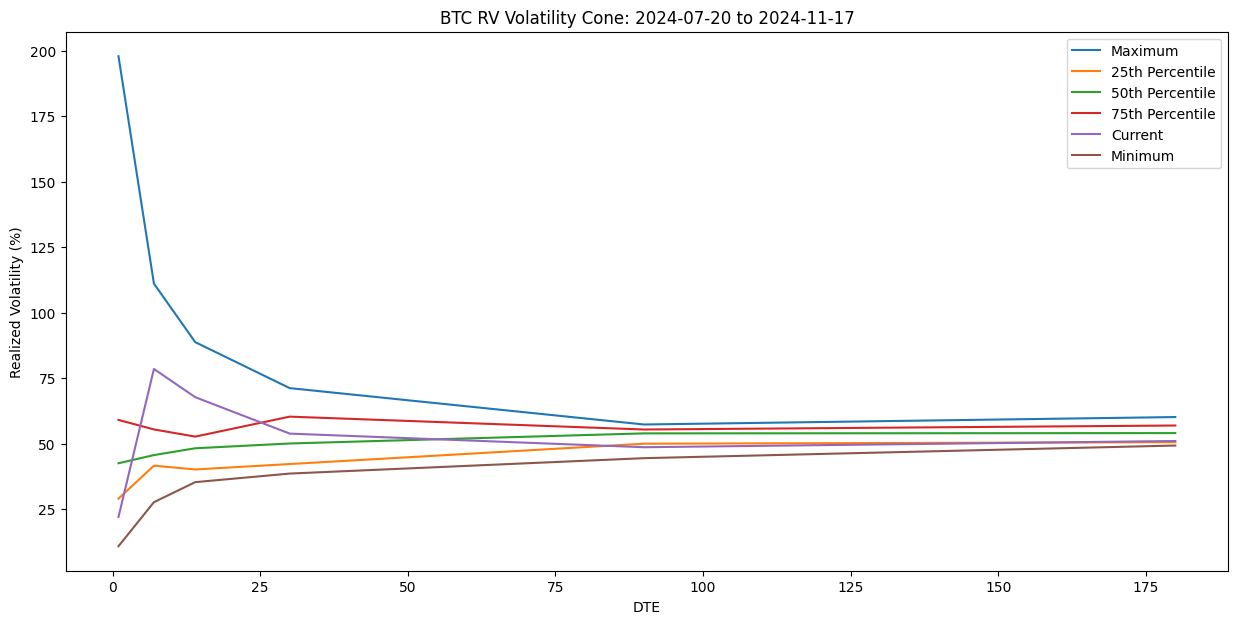

In [7]:
last_x_days = 120 # 4 months

now        = datetime.datetime.now()
end_date   = now.strftime('%Y-%m-%d')
start_date = (now + datetime.timedelta(days=-last_x_days)).strftime('%Y-%m-%d')

data = amberdata_client.get_realized_volatility_cones(exchange='gdax', pair='btc_usd', startDate=start_date, endDate=end_date)
data = pd.DataFrame(data['payload']['data'])
data = data.drop(columns=['exchange', 'pair']).T

data['dte'] = [
    int(''.join([char for char in column.split("_")[1] if char.isdigit()]))
    for column in data.index
]
data['vol_level'] = [data.index[i].split("_")[0] for i in range(len(data))]
data.columns = ['rv', 'dte', 'vol_level']

cone_max = data[data.vol_level=='max'].sort_values('dte', ascending=True)
cone_min = data[data.vol_level=='min'].sort_values('dte', ascending=True)
cone_25p = data[data.vol_level=='p25'].sort_values('dte', ascending=True)
cone_50p = data[data.vol_level=='p50'].sort_values('dte', ascending=True)
cone_75p = data[data.vol_level=='p75'].sort_values('dte', ascending=True)
cone_current = data[data.vol_level=='current'].sort_values('dte', ascending=True)

plt.figure(figsize=(15, 7))
plt.plot(cone_max.dte, cone_max.rv, label='Maximum')
plt.plot(cone_25p.dte, cone_25p.rv, label='25th Percentile')
plt.plot(cone_50p.dte, cone_50p.rv, label='50th Percentile')
plt.plot(cone_75p.dte, cone_75p.rv, label='75th Percentile')
plt.plot(cone_current.dte, cone_current.rv, label='Current')
plt.plot(cone_min.dte, cone_min.rv, label='Minimum')

plt.legend()
plt.title(f"BTC RV Volatility Cone: {start_date} to {end_date}")
plt.ylabel("Realized Volatility (%)")
plt.xlabel("DTE")

In [8]:
# IV vs RV + VRP

Text(0.5, 0, 'Size Vega')

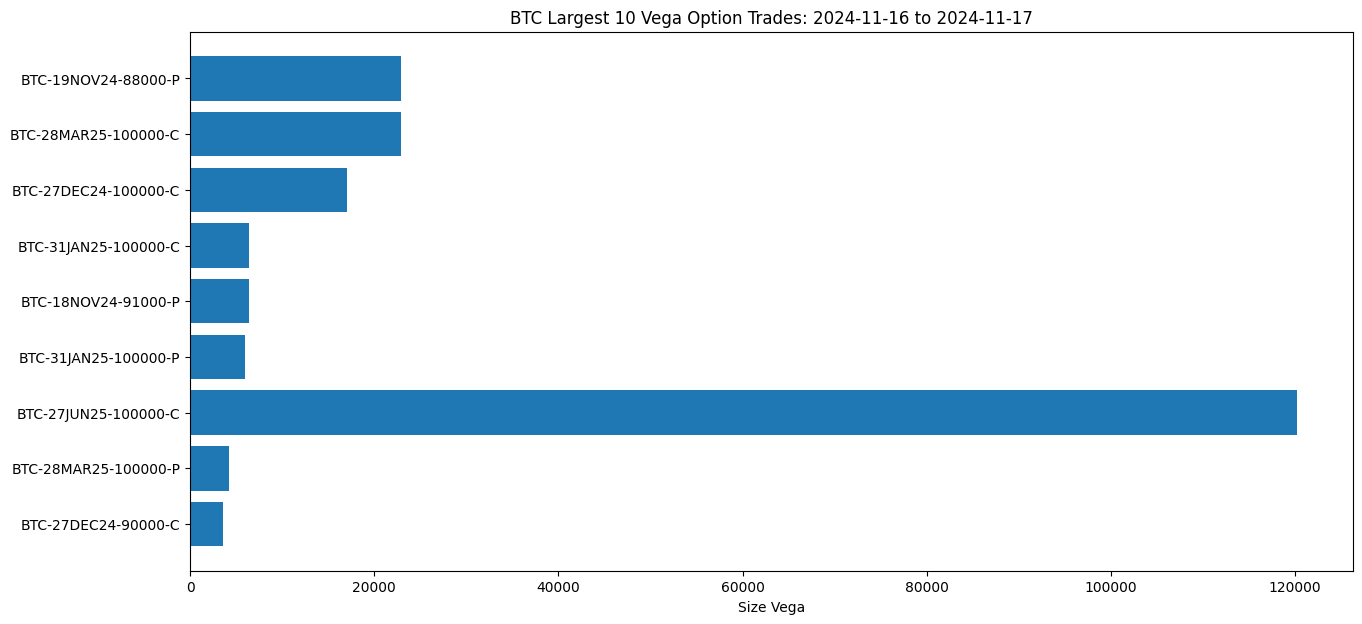

In [9]:
now        = datetime.datetime.now()
end_date   = now.strftime('%Y-%m-%d')
start_date = (now + datetime.timedelta(days=-1)).strftime('%Y-%m-%d')

data = amberdata_client.get_options_scanner_top_trades(exchange='deribit', currency='btc', startDate=start_date, endDate=end_date)
data = pd.DataFrame(data['payload']['data'])

# only look at top 10 & sort by descending order 
data = data.sort_values("sizeVega", ascending=False).head(10).reset_index(drop=True)

plt.figure(figsize=(15, 7))
plt.barh(data.instrument, data.sizeVega[::-1])
plt.title(f"BTC Largest 10 Vega Option Trades: {start_date} to {end_date}")
plt.xlabel("Size Vega")